In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from scipy.signal import find_peaks, periodogram
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

# plt.rcParams['figure.dpi'] = 150

In [16]:
TEST_SIZE = 0.5
SEASON = 14
BOXCOX = True
ALPHA = 0.05
DPI = 150

In [17]:
daily_summary = pd.read_parquet('../clean_data/avg_global.parquet')

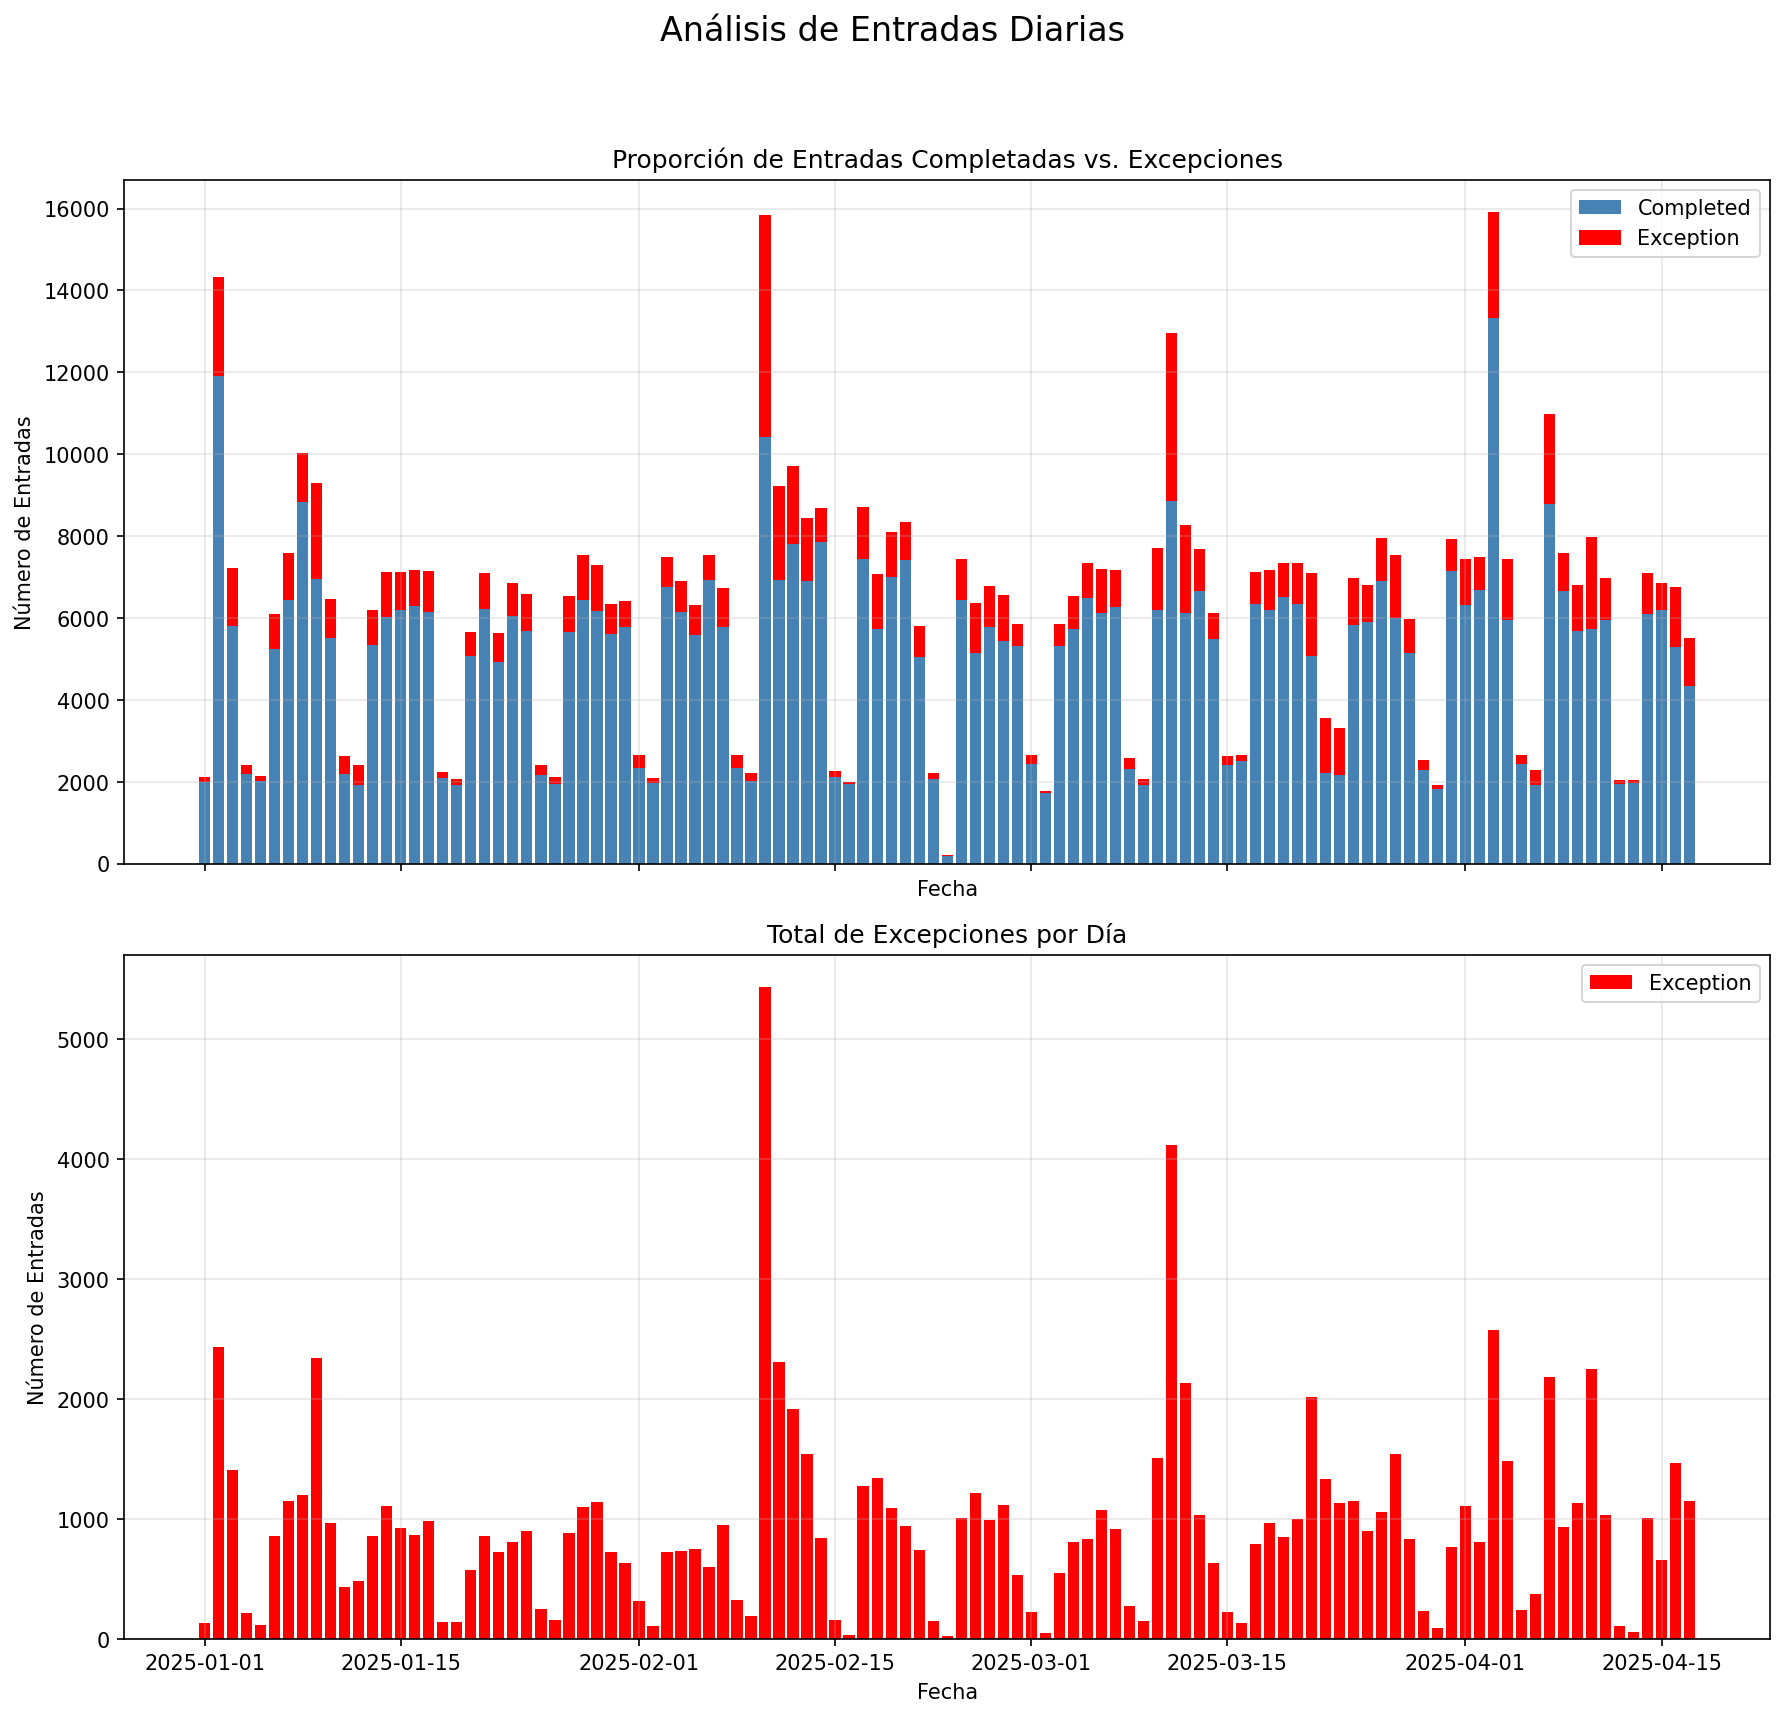

In [18]:
daily_summary['Completed'] = daily_summary['entries'] * (1 - daily_summary['tasa_excepcion'])
daily_summary['Exception'] = daily_summary['entries'] * daily_summary['tasa_excepcion']

fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True
                         )
fig.suptitle('Análisis de Entradas Diarias', fontsize=16)

axes[0].bar(daily_summary.index, daily_summary['Completed'], label='Completed', color='steelblue')
axes[0].bar(daily_summary.index, daily_summary['Exception'], bottom=daily_summary['Completed'], label='Exception', color='red')
axes[0].set_title('Proporción de Entradas Completadas vs. Excepciones')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Número de Entradas')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].bar(daily_summary.index, daily_summary['Exception'], label='Exception', color='red')
axes[1].set_title('Total de Excepciones por Día')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Número de Entradas')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Lambda óptima: 0.3555


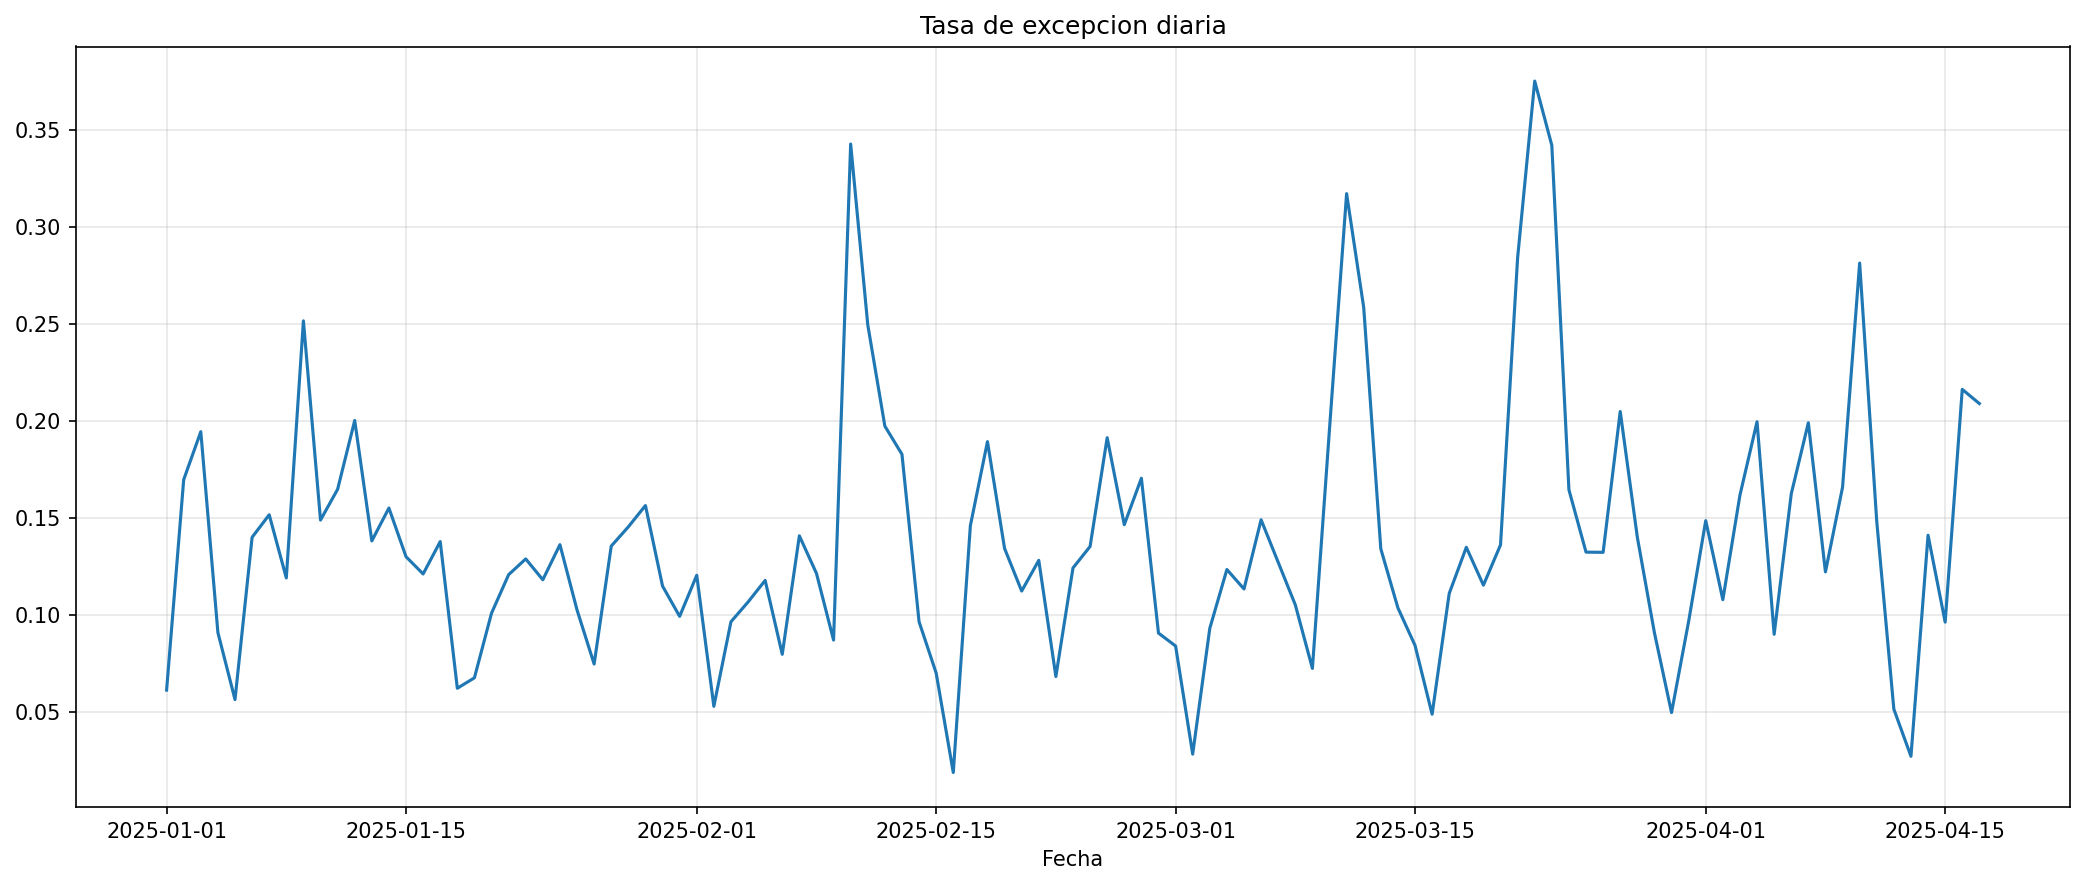

In [19]:
transformed_data, best_lambda = stats.boxcox(daily_summary['tasa_excepcion'])
daily_summary['tasa_excepcion_boxcox'] = transformed_data

print(f"Lambda óptima: {best_lambda:.4f}")

fig, ax = plt.subplots(figsize=(14, 6))
daily_summary['tasa_excepcion'].plot(ax=ax, title='Tasa de excepcion diaria')
ax.set_xlabel('Fecha')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

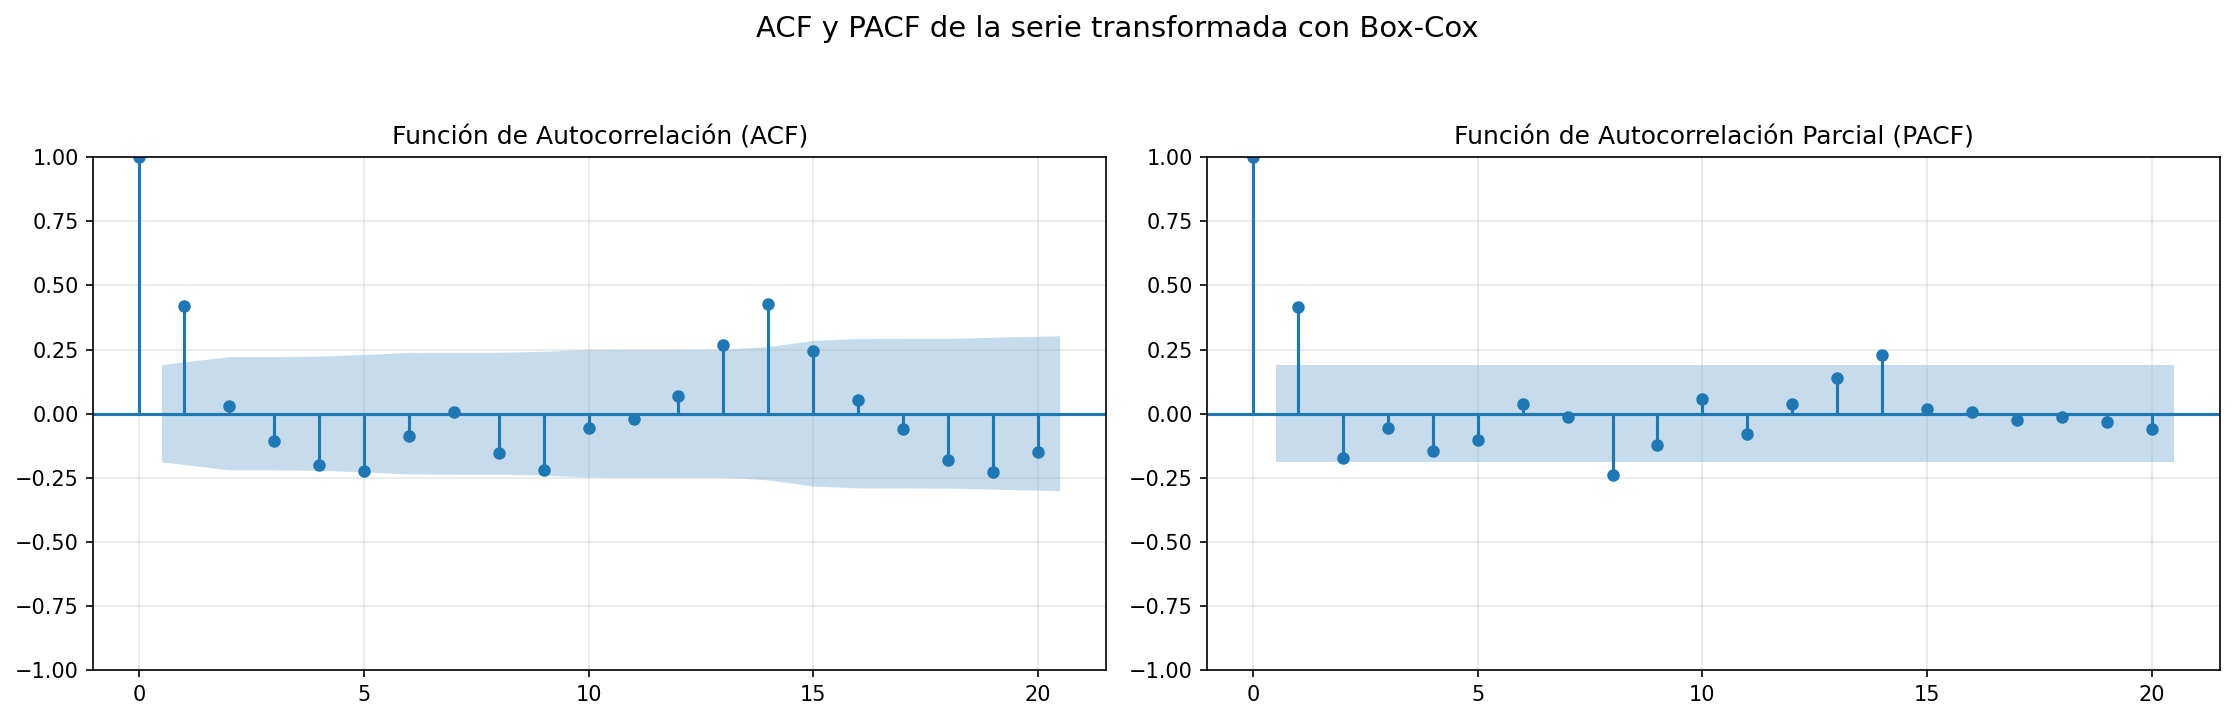

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('ACF y PACF de la serie transformada con Box-Cox', fontsize=14)

plot_acf(
    daily_summary['tasa_excepcion_boxcox'].dropna(),
    ax=axes[0],
    lags=20,
    alpha=ALPHA,
    title='Función de Autocorrelación (ACF)',
    adjusted=True
)
axes[0].grid(True, alpha=0.3)

plot_pacf(
    daily_summary['tasa_excepcion_boxcox'].dropna(),
    ax=axes[1],
    lags=20,
    alpha=ALPHA,
    title='Función de Autocorrelación Parcial (PACF)'
)
axes[1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

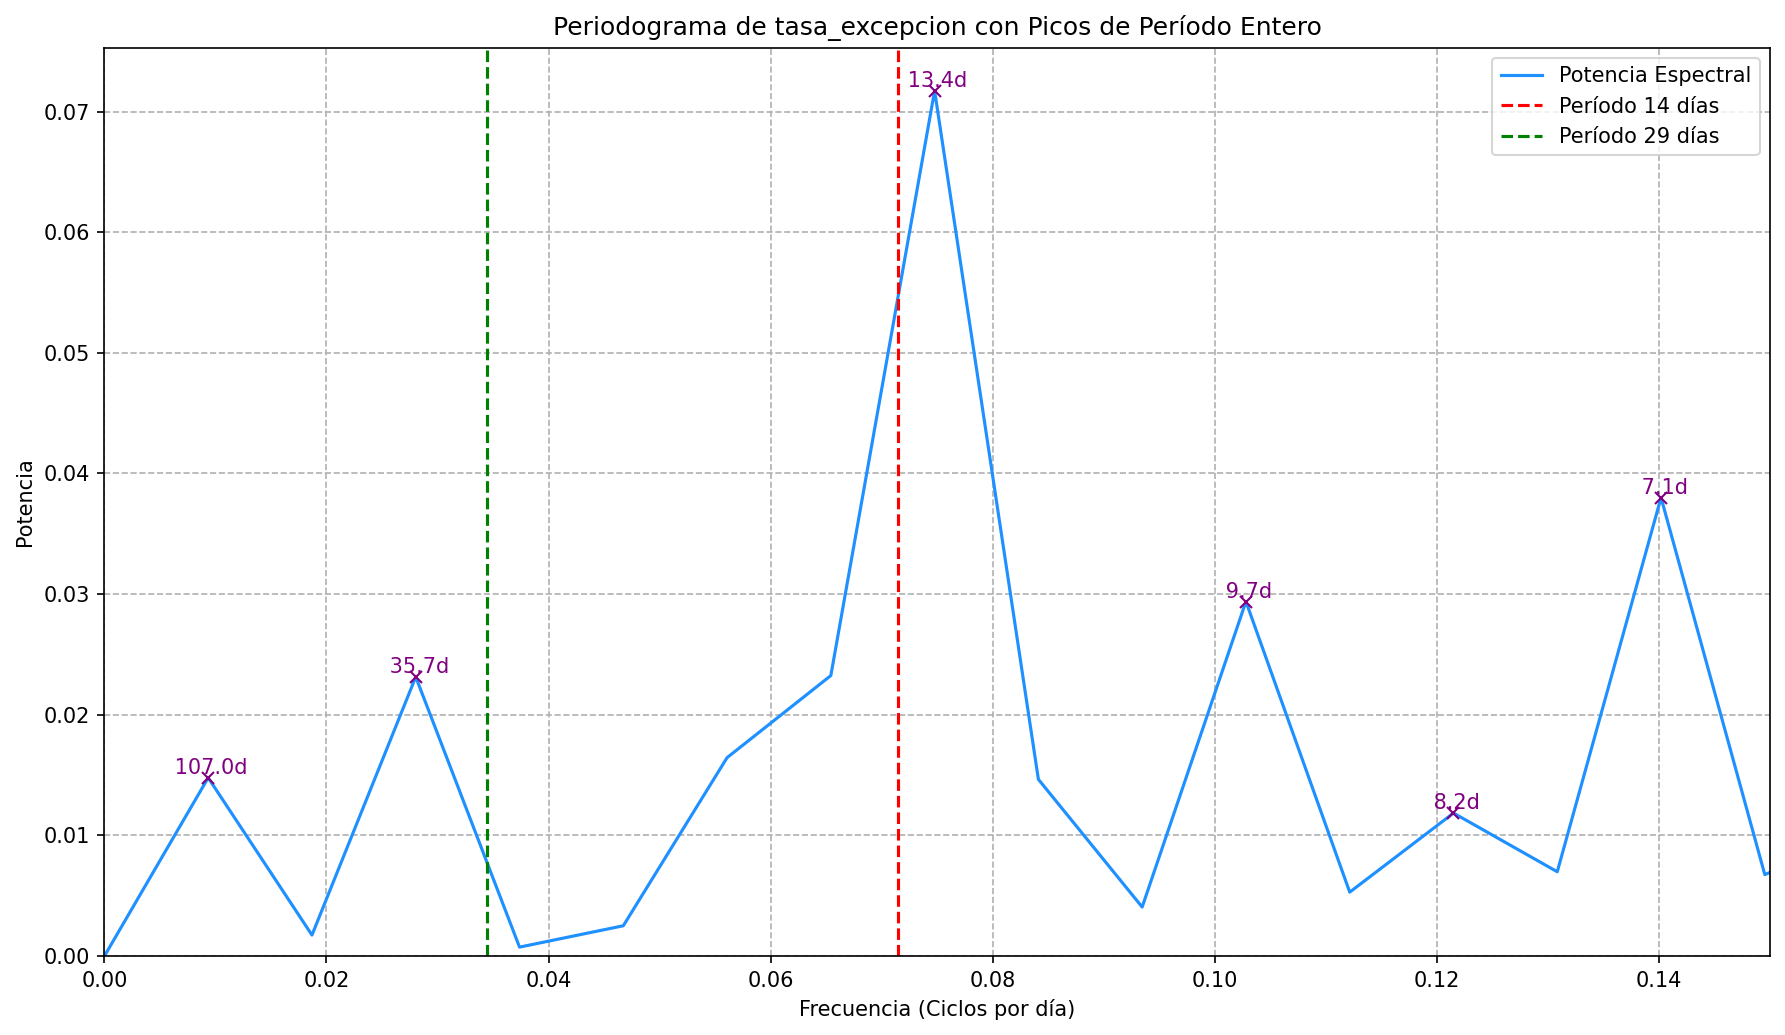

In [21]:
time_series = daily_summary['tasa_excepcion'].dropna()
frequencies, power = periodogram(time_series, fs=1)

fig, ax = plt.subplots(figsize=(12, 7))

height_threshold = np.mean(power)
peak_indices, _ = find_peaks(power, height=height_threshold)

ax.plot(frequencies, power, color='dodgerblue', label='Potencia Espectral')

labeled_periods = set()

for i in peak_indices:
    freq = frequencies[i]
    if freq > 0.15 or freq == 0:
        continue

    period = 1 / freq
    rounded_period = round(period,1)
    
    if rounded_period not in labeled_periods:
        pwr = power[i]
        ax.plot(freq, pwr, "x", color="purple")
        ax.text(freq, pwr, f" {rounded_period}d", verticalalignment='bottom', ha='center', color='purple')
        labeled_periods.add(rounded_period)


ax.axvline(x=1/14, color='red', linestyle='--', linewidth=1.5, label='Período 14 días')
ax.axvline(x=1/29, color='green', linestyle='--', linewidth=1.5, label='Período 29 días')

ax.set_title('Periodograma de tasa_excepcion con Picos de Período Entero')
ax.set_xlabel('Frecuencia (Ciclos por día)')
ax.set_ylabel('Potencia')
ax.legend()
ax.grid(True, linestyle='--')
ax.set_xlim(0, 0.15)
ax.set_ylim(0)

plt.tight_layout()
plt.show()


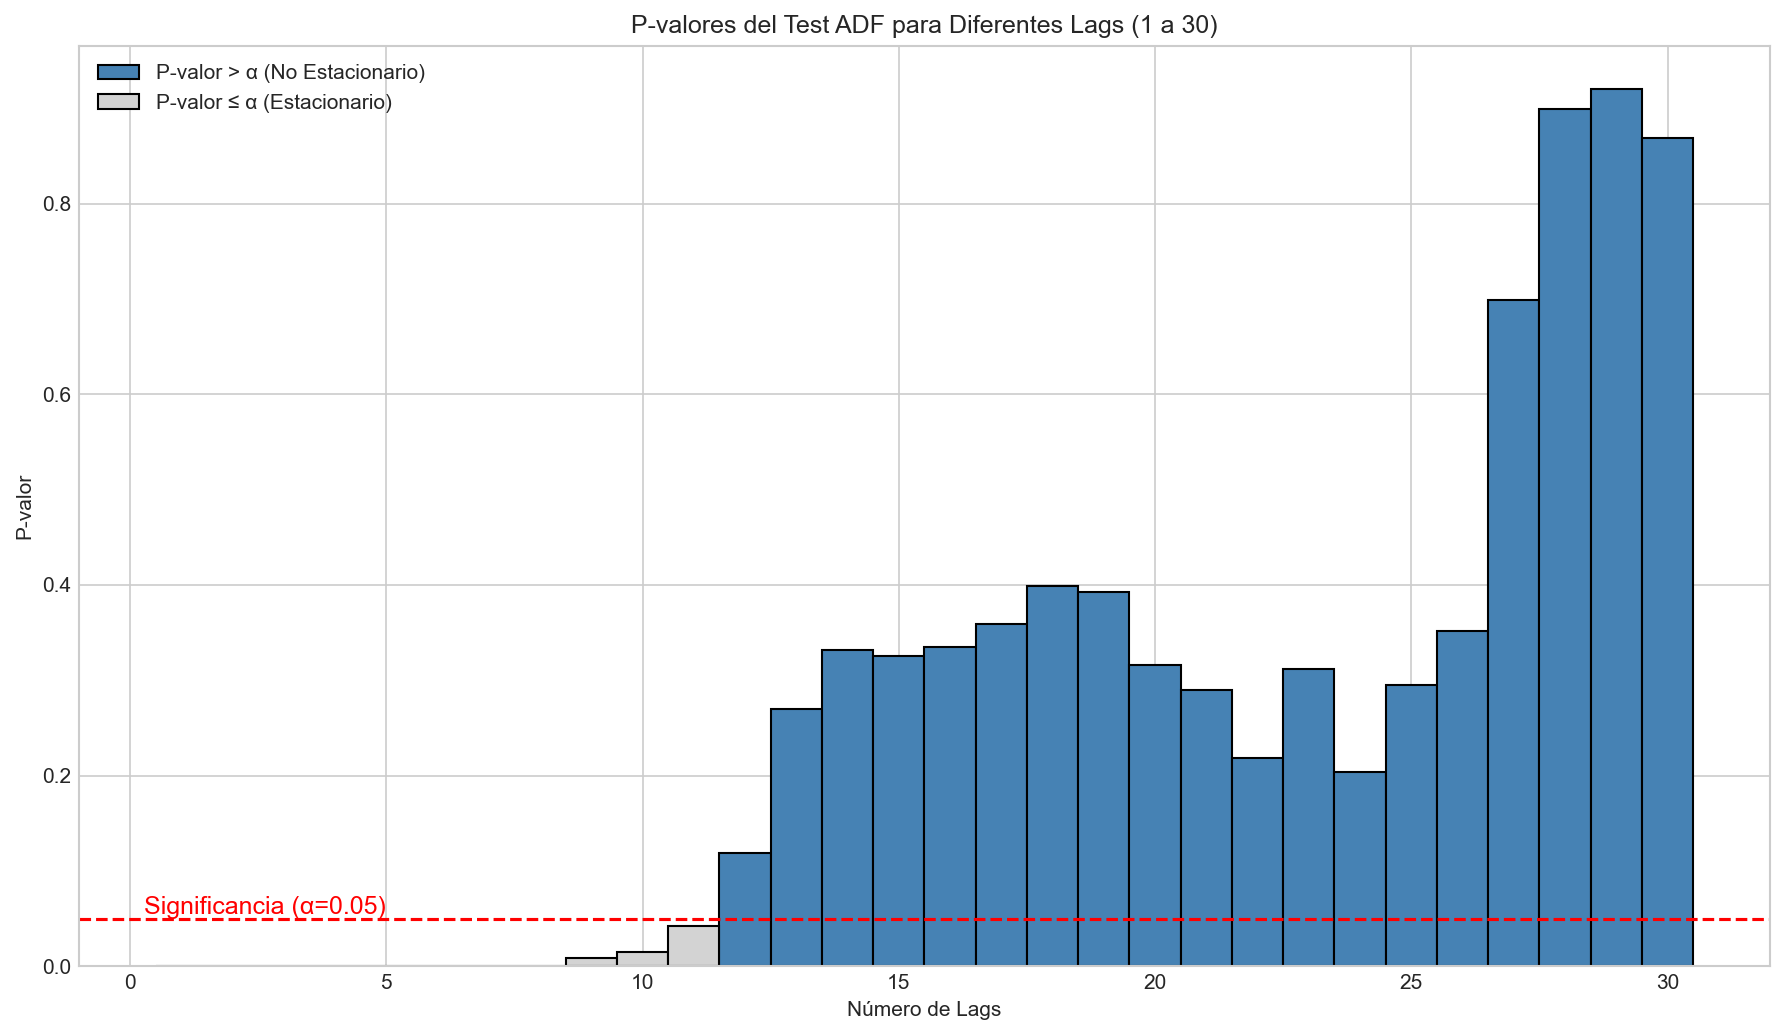

In [22]:
plt.style.use('seaborn-v0_8-whitegrid')

serie_adf = daily_summary['tasa_excepcion'].dropna()
max_lags_adf = 30

p_values = []
lags_range = range(1, max_lags_adf + 1)

for i in lags_range:
    adf_result = adfuller(serie_adf, maxlag=i, autolag=None)
    p_values.append(adf_result[1])

adf_pvals_df = pd.DataFrame({'Lag': list(lags_range), 'P-Value': p_values})

fig, ax = plt.subplots(figsize=(12, 7))

# Destacar los valores no estacionarios
above_alpha = adf_pvals_df[adf_pvals_df['P-Value'] > ALPHA]
below_alpha = adf_pvals_df[adf_pvals_df['P-Value'] <= ALPHA]

ax.bar(above_alpha['Lag'], above_alpha['P-Value'], width=1.0, color='steelblue', label='P-valor > α (No Estacionario)', edgecolor='black', linewidth=1)
ax.bar(below_alpha['Lag'], below_alpha['P-Value'], width=1.0, color='lightgray', label='P-valor ≤ α (Estacionario)', edgecolor='black', linewidth=1)

ax.axhline(y=ALPHA, color='red', linestyle='--')
ax.text(0, ALPHA, f'  Significancia (α={ALPHA})', ha='left', va='bottom', color='red', fontsize=12)

ax.set_title(f'P-valores del Test ADF para Diferentes Lags (1 a {max_lags_adf})')
ax.set_xlabel('Número de Lags')
ax.set_ylabel('P-valor')
ax.legend()

plt.tight_layout()
plt.show()

plt.style.use('default')
plt.rcParams['figure.dpi'] = DPI


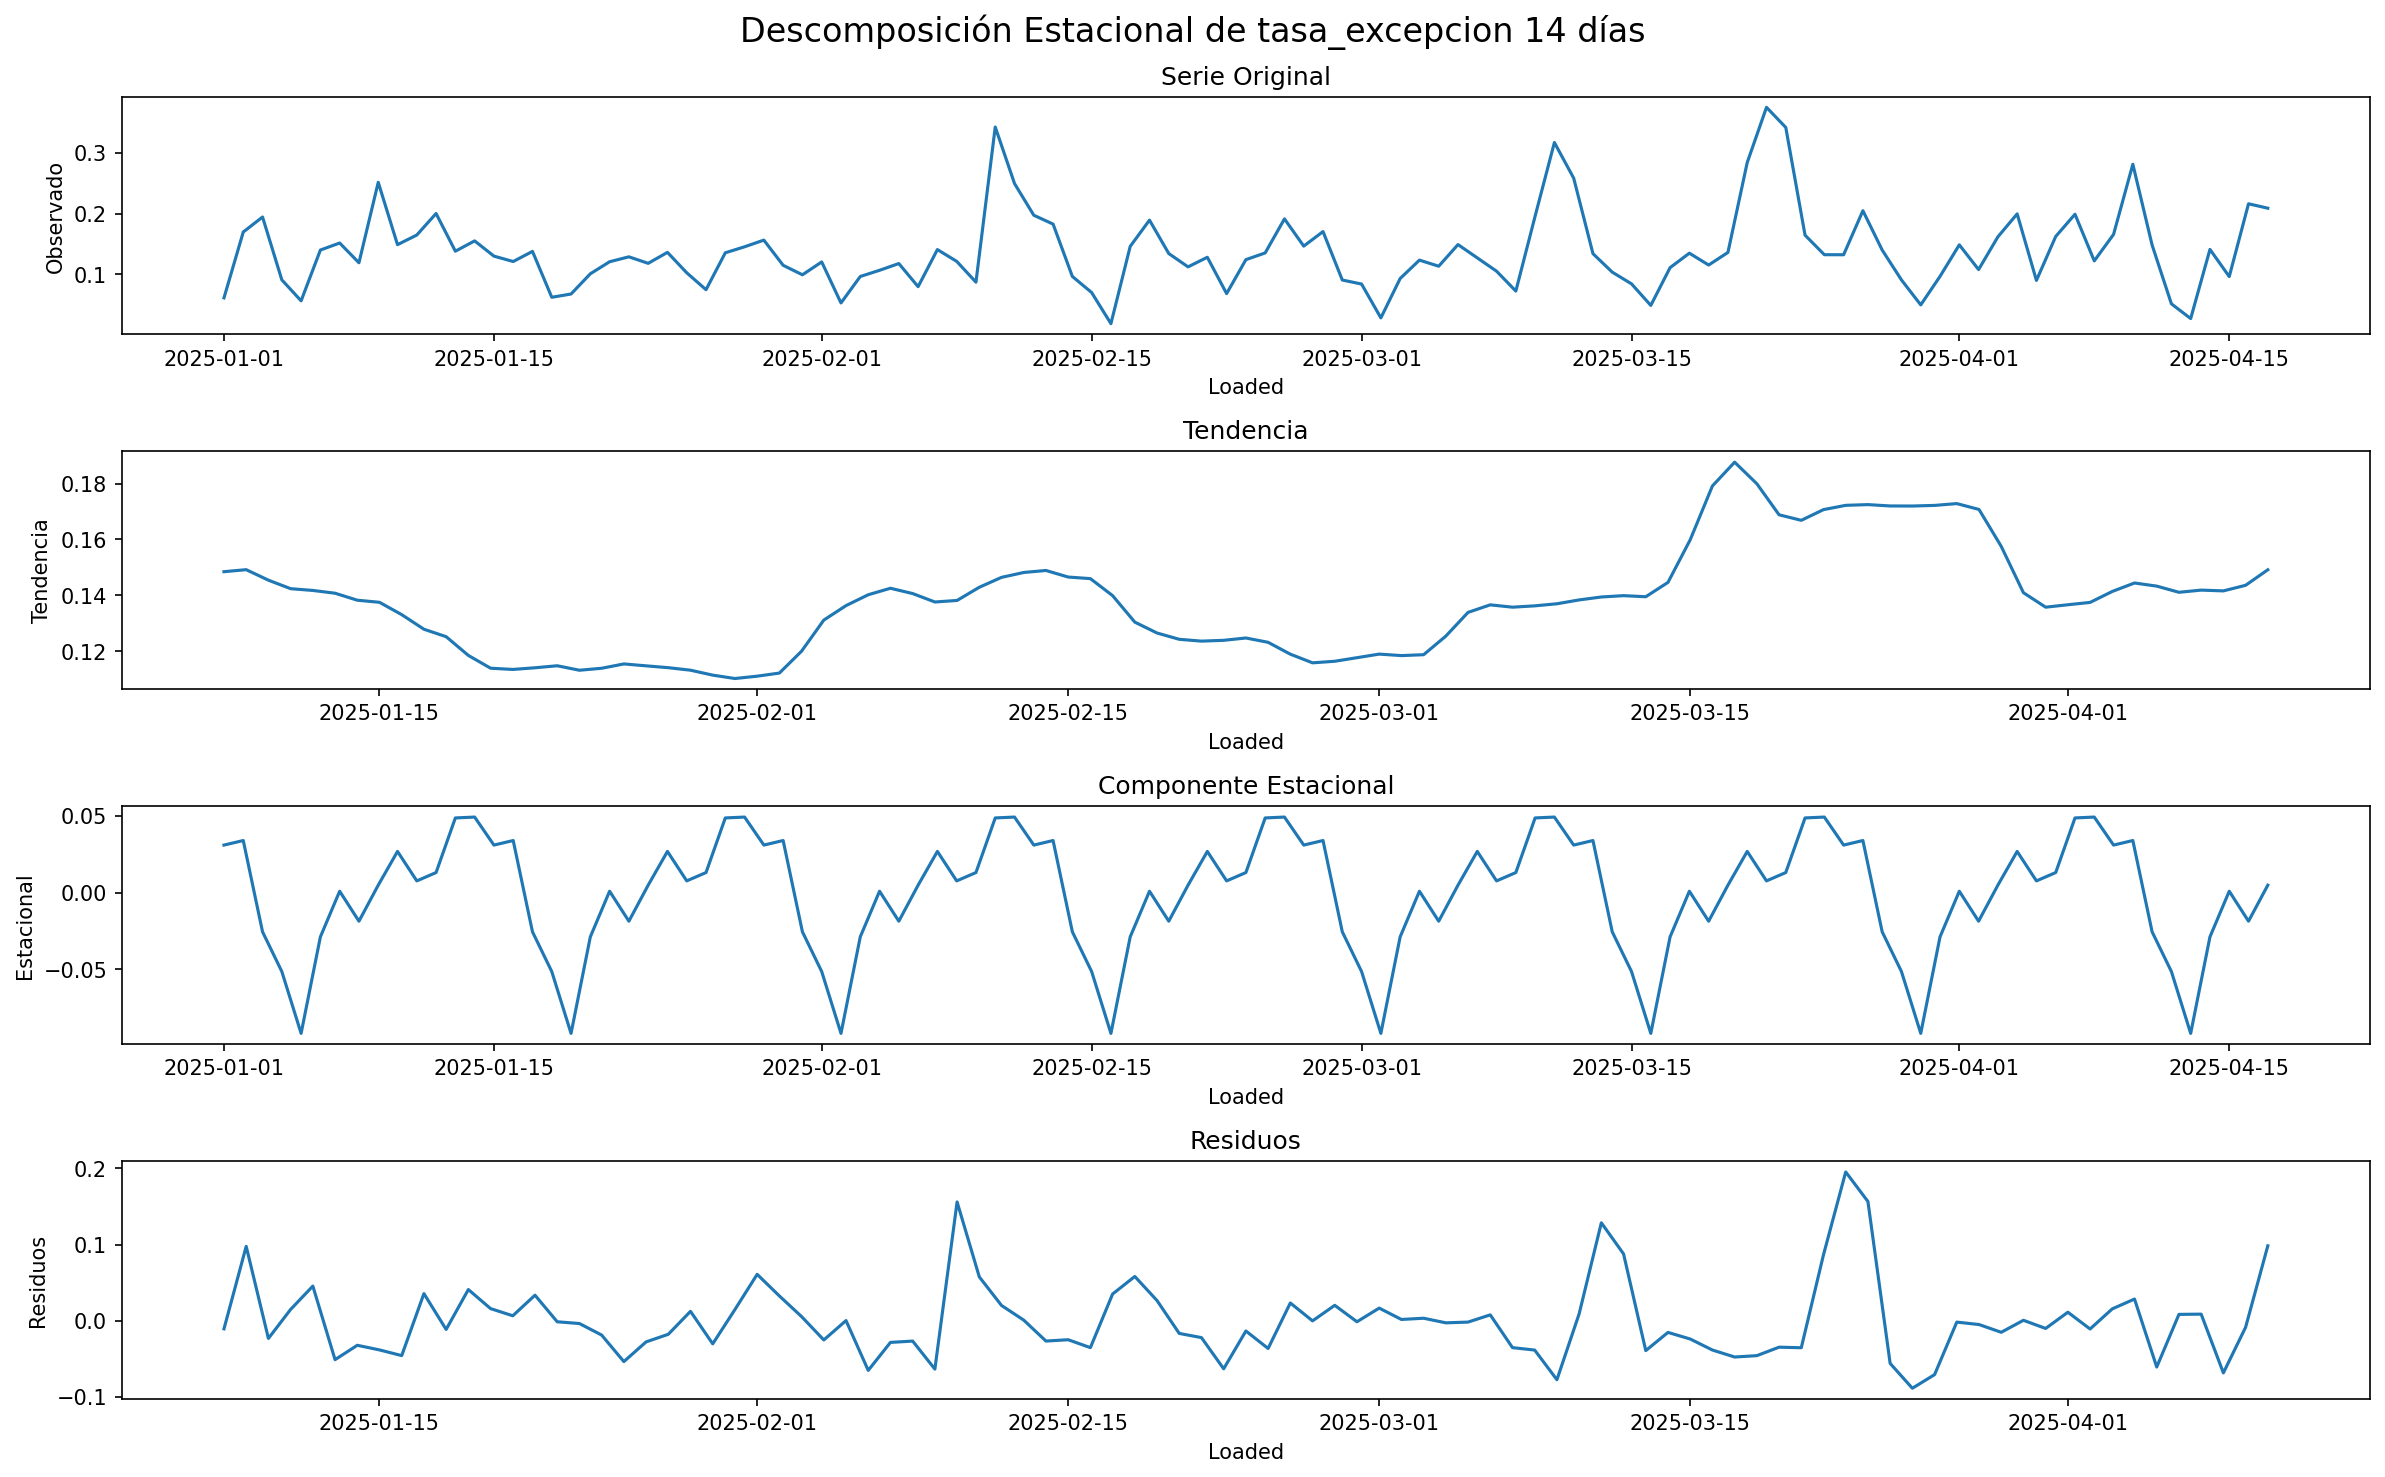

In [23]:
decomposition = seasonal_decompose(
    daily_summary['tasa_excepcion'],
    model='add',
    period=SEASON,
)

fig, axes = plt.subplots(4, 1, figsize=(16, 10))
fig.suptitle(f'Descomposición Estacional de tasa_excepcion {SEASON} días', fontsize=16)

decomposition.observed.plot(ax=axes[0], title='Serie Original')
axes[0].set_ylabel('Observado')

decomposition.trend.plot(ax=axes[1], title='Tendencia')
axes[1].set_ylabel('Tendencia')

decomposition.seasonal.plot(ax=axes[2], title='Componente Estacional')
axes[2].set_ylabel('Estacional')

decomposition.resid.plot(ax=axes[3], title='Residuos')
axes[3].set_ylabel('Residuos')

plt.tight_layout()
plt.show()

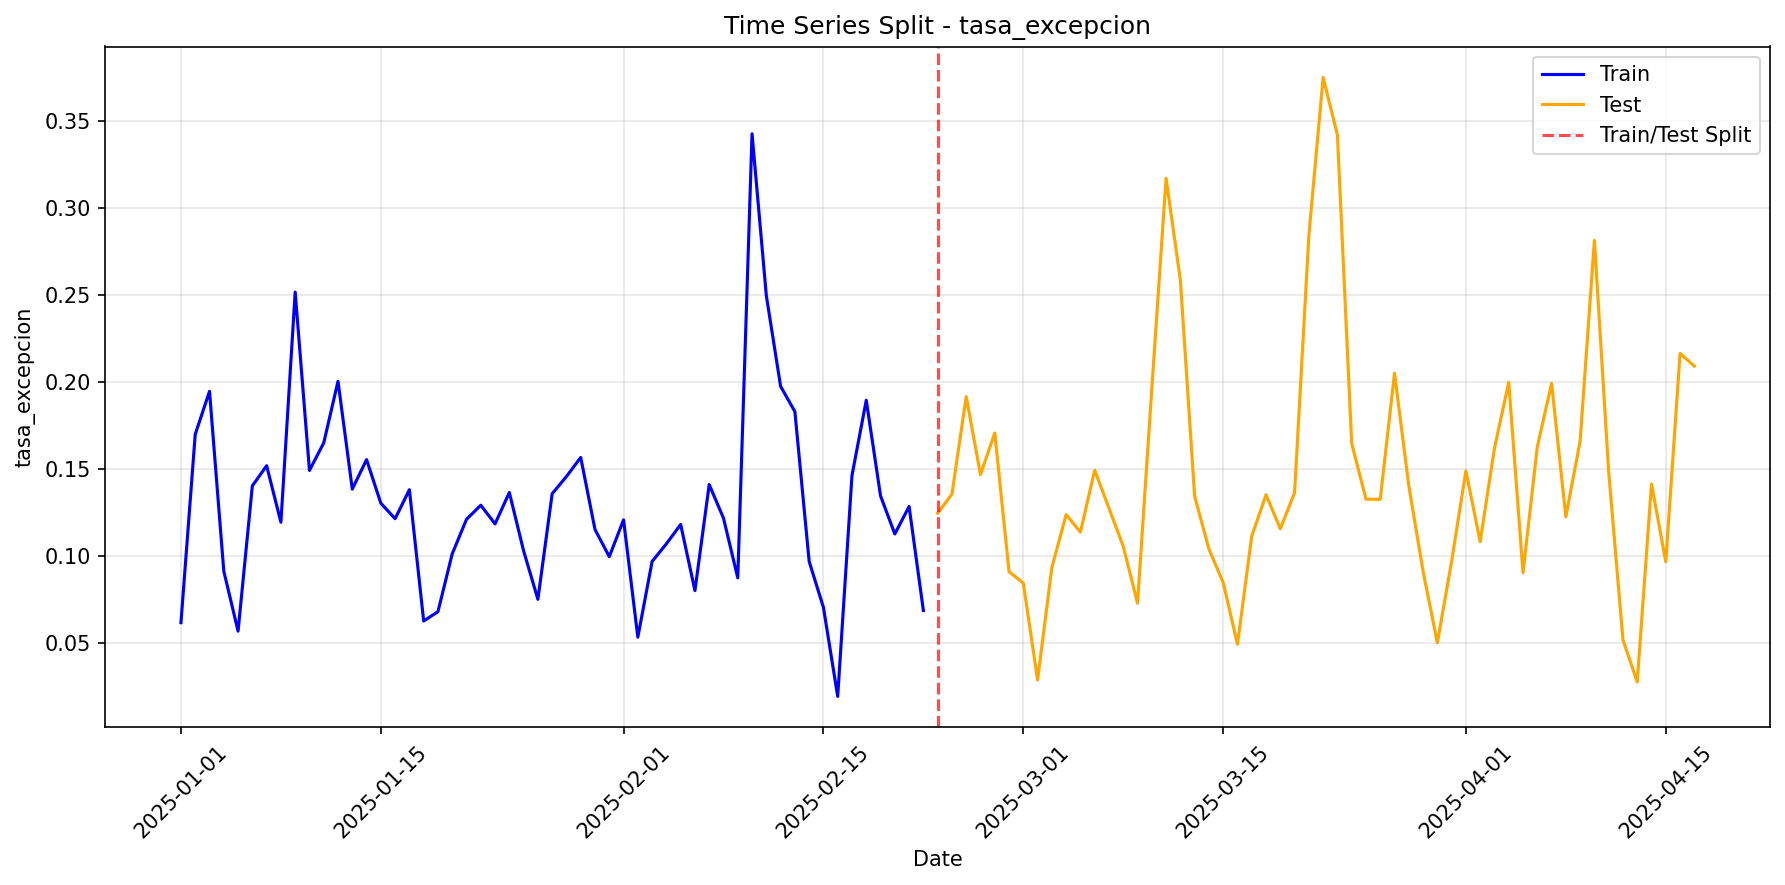

In [24]:
train, test = train_test_split(
    daily_summary['tasa_excepcion'],
    test_size=TEST_SIZE,
    shuffle=False
)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train', color='blue')
plt.plot(test.index, test.values, label='Test', color='orange')
plt.axvline(
    x=test.index[0],
    color='red',
    linestyle='--',
    alpha=0.7,
    label='Train/Test Split'
)
plt.xlabel('Date')
plt.ylabel('tasa_excepcion')
plt.title('Time Series Split - tasa_excepcion')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
model_auto = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=SEASON,
    initialization_method='estimated',
    use_boxcox=BOXCOX,
).fit()

print("Modelo ETS Automático:")
print(f"AIC: {model_auto.aic:.2f}")
print(f"BIC: {model_auto.bic:.2f}")
print(f"Alpha (nivel): {model_auto.params['smoothing_level']:.4f}")
print(f"Beta (tendencia): {model_auto.params['smoothing_trend']:.4f}")
print(f"Gamma (estacional): {model_auto.params['smoothing_seasonal']:.4f}")

forecast_steps = len(test)
forecast = model_auto.forecast(steps=forecast_steps)
forecast_index = test.index

forecast_train = model_auto.fittedvalues

Modelo ETS Automático:
AIC: -297.73
BIC: -262.26
Alpha (nivel): 0.0000
Beta (tendencia): 0.0000
Gamma (estacional): 0.0000


c:\Users\santi\Documents\Codigo\proyecto de grado\Prediccion_de_fallas\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


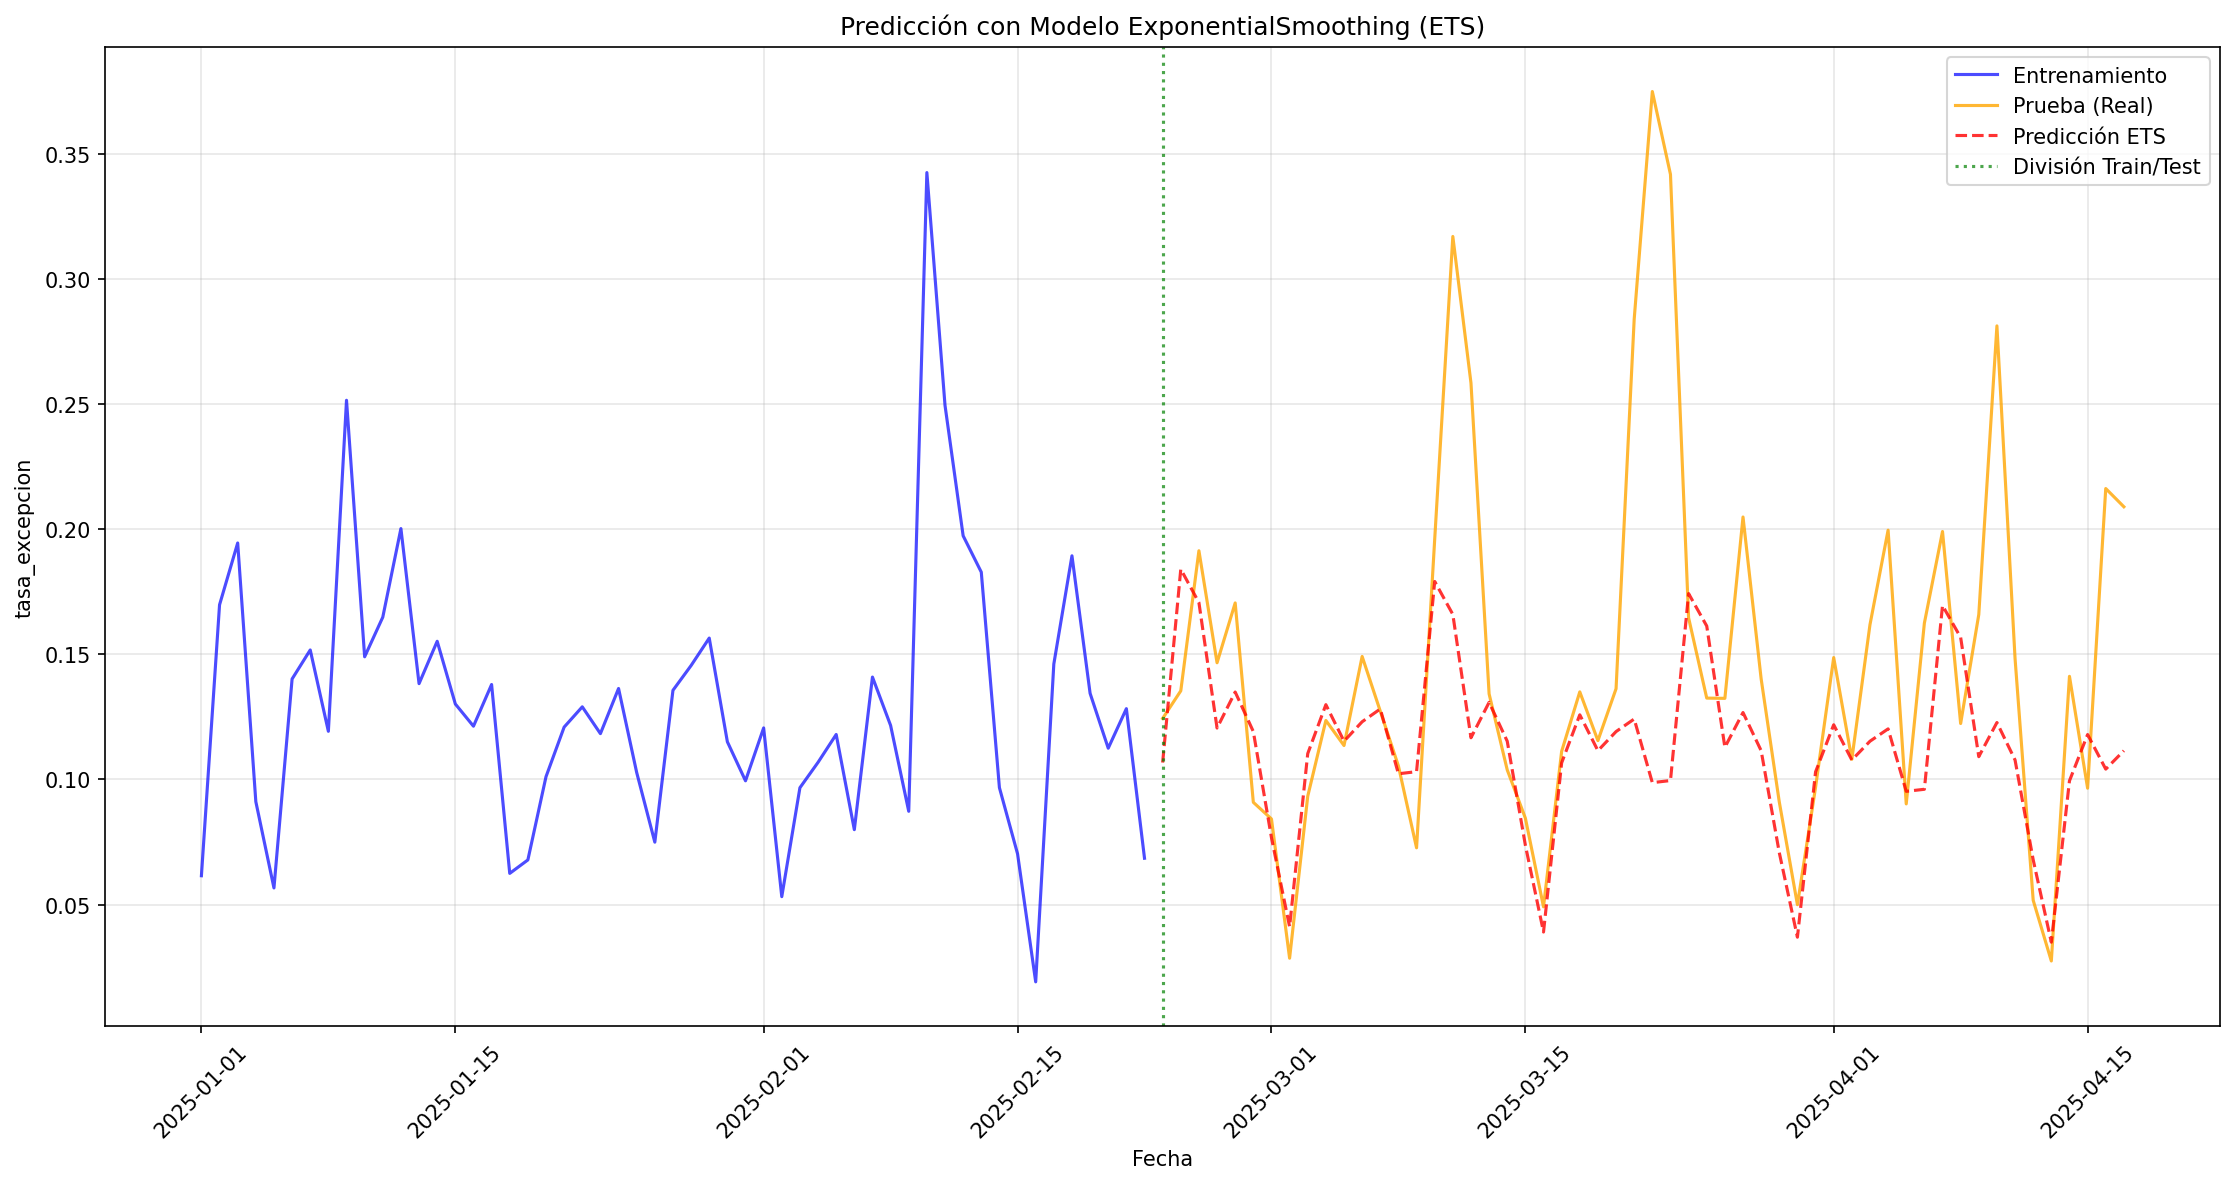

In [26]:
train_orig, test_orig = train_test_split(
    daily_summary['tasa_excepcion'], test_size=TEST_SIZE, shuffle=False
)

plt.figure(figsize=(15, 8))

plt.plot(train.index, train.values, label='Entrenamiento', color='blue', alpha=0.7)
plt.plot(test.index, test.values, label='Prueba (Real)', color='orange', alpha=0.8)
plt.plot(forecast_index, forecast, label='Predicción ETS', color='red', alpha=0.8, linestyle='--')

plt.axvline(
    x=test.index[0],
    color='green',
    linestyle=':',
    alpha=0.7,
    label='División Train/Test'
)

plt.xlabel('Fecha')
plt.ylabel('tasa_excepcion')
plt.title('Predicción con Modelo ExponentialSmoothing (ETS)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
train_orig, test_orig = train_test_split(
    daily_summary['tasa_excepcion'], test_size=TEST_SIZE, shuffle=False
)

mae_train = mean_absolute_error(train, forecast_train)
mse_train = mean_squared_error(train, forecast_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(train, forecast_train)
mase_train = mean_absolute_scaled_error(train, forecast_train, y_train=train)

mae_test = mean_absolute_error(test, forecast)
mse_test = mean_squared_error(test, forecast)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(test, forecast)
mase_test = mean_absolute_scaled_error(test, forecast, y_train=train)

metricas_df = pd.DataFrame({
    'Train': [mae_train, mse_train, rmse_train, r2_train, mase_train],
    'Test': [mae_test, mse_test, rmse_test, r2_test, mase_test]
}, index=['MAE', 'MSE', 'RMSE', 'R²', 'MASE'])

train_diff = np.diff(train)
forecast_train_diff = np.diff(forecast_train)
min_len_train = min(len(train_diff), len(forecast_train_diff))
train_diff_aligned = train_diff[:min_len_train]
forecast_train_diff_aligned = forecast_train_diff[:min_len_train]
da_train = np.mean( (np.sign(train_diff_aligned) == np.sign(forecast_train_diff_aligned)).astype(int) ) * 100

test_diff = np.diff(test)
forecast_diff = np.diff(forecast)
min_len_test = min(len(test_diff), len(forecast_diff))
test_diff_aligned = test_diff[:min_len_test]
forecast_diff_aligned = forecast_diff[:min_len_test]
da_test = np.mean( (np.sign(test_diff_aligned) == np.sign(forecast_diff_aligned)).astype(int) ) * 100

metricas_df.loc['DA (%)'] = [da_train, da_test]

metricas_df.round(4)

residuals = test - forecast
metricas_df

,Train,Test
MAE,0.031283,0.044221
MSE,0.001842,0.005408
RMSE,0.042923,0.073538
R²,0.388642,-0.004329
MASE,0.679535,0.960585
DA (%),61.538462,77.358491


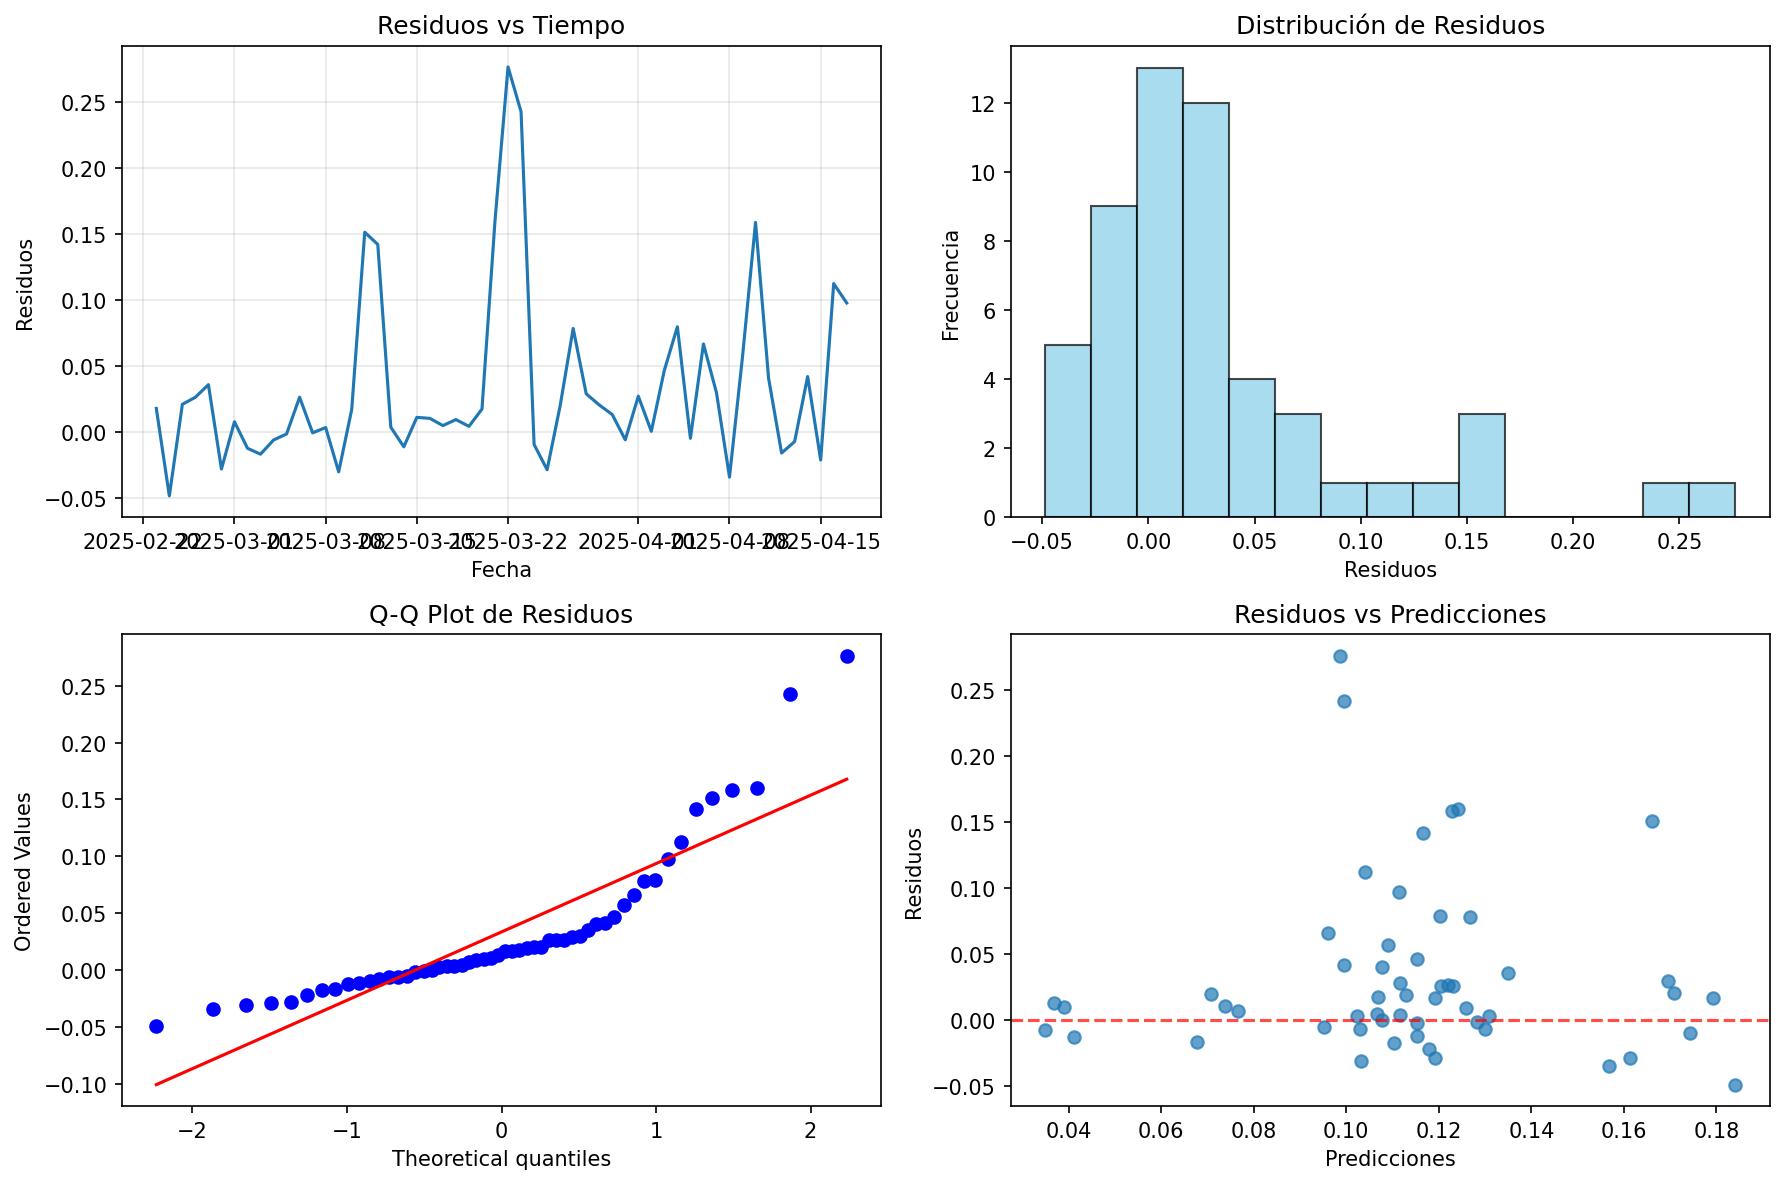

In [28]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(forecast_index, residuals)
plt.title('Residuos vs Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.hist(residuals, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribución de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot de Residuos')

plt.subplot(2, 2, 4)
plt.scatter(forecast, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.title('Residuos vs Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')

plt.tight_layout()
plt.show()